SANGINETO JUCA Marina & MOREIRA TEIXEIRA Luiz Fernando

This practical work, on motion estimation, has 2 different parts, corresponding to two families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d



# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [2]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

(288, 352)

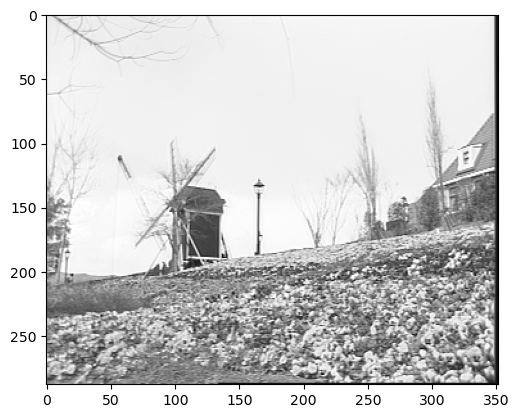

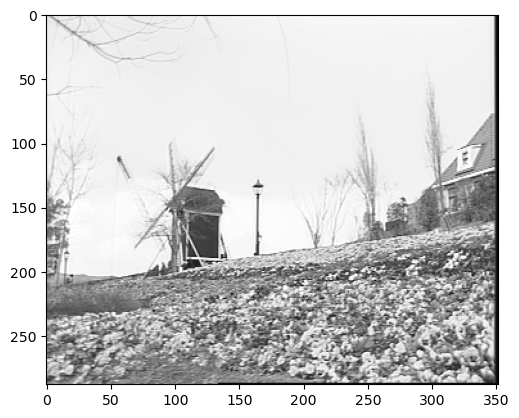

In [3]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')
im1.shape

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [4]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius

Fill the me_ssd function in the cell below. First, implement the unregularized part of the function (you will implement the regularized one later). Do not pay attention to the computePredictor and initVector (we will speak about them later on).

In [5]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) 
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))

    m, n = cur.shape
    
    # Non-regularized search
    if lamb == 0.:
        for r in range(0, m, bcol): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, n, brow):
                # current block selection
                B = cur[r : r + brow, c : c + bcol] # Block
                
                # Initialization:
                
                costMin = np.inf
                
                Rbest = np.zeros((brow, bcol))

                # Loop on candidate displacement vectors
                for dcol in range(c-search,search+c): # dcol = candidate displacement vector over the columns
                    for drow in range(r-search,search+r):# rcol = candidate displacement vector over the rows
                        
                        B_ref = ref_extended[
                        extension + drow : extension +  brow + drow,
                        extension + dcol : extension +  bcol + dcol
                        ]

                        cost = np.linalg.norm(B - B_ref, ord=2)**2
                        
                        if cost <= costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            r_disp = drow
                            c_disp = dcol
                            Rbest = B_ref
                            
                mvf[r : r + brow, c : c + bcol,0] = r - r_disp # Once the loop is over, save the best row displacement field
                mvf[r : r + brow, c : c + bcol,1] = c - c_disp # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol] = Rbest 

                
    else: # Regularized search
        for r in range(0, m, brow) : # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, n , bcol) :
                # current block selection
                B = cur[r : r + brow, c : c + bcol] # Block

                # Initializations          
                
                costMin = np.inf
                Rbest = np.zeros((brow, bcol))
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur) 
                
                # Loop on candidate vectors
                for dcol in range(c-search,search+c): # dcol = candidate displacement vector over the columns
                    for drow in range(r-search,search+r): # rcol = candidate displacement vector over the rows
                        
                        B_ref = ref_extended[
                        extension + drow : extension + brow + drow,
                        extension + dcol : extension + bcol + dcol
                        ]
                        
                        reg_term = lamb * np.sum(np.abs((np.array([drow, dcol]) - pV)))
                        ssd = np.linalg.norm(B - B_ref, ord=2)**2
                        cost = ssd + reg_term # here, encore the REGULARIZED cost function
                        if cost <= costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            r_disp = drow
                            c_disp = dcol
                            Rbest = B_ref
                
                
                mvf[r : r + brow, c : c + bcol,0] = r - r_disp  # Once the loop is over, save the best row displacement field
                mvf[r : r + brow, c : c + bcol,1] = c - c_disp  # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [6]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

In [7]:
mvf_ssd_reg,prediction_reg =  me_ssd(im2, im1, brow, bcol, search_radius, lamb=0)

**Q1:** Using the function displayMVF, show the motion vector field. Write your remarks. Are there errors? If yes, where and why?

Change the block size and the search area radius. How does it impact your results?

**A1:** A few remarks can be made:

- Smaller blocks capture details but increase computation.  
- Larger blocks are efficient but may miss small motions.  
- Wider search radius improves accuracy but is slower.
- $\lambda$ balances accuracy and smoothness.  
- Regularization penalizes large deviations, improving motion consistency.

Errors:

- In uniform areas (e.g., the sky), the lack of features can cause inaccurate motion vectors. The algorithm may assign random matches, leading to errors. Solutions include advanced estimation methods, pre-processing, or tuning $\lambda$ for better stability.  

PS.: The code with search radius change plots is in section I-2, as well as other modifications on each parameter that are also used for following questions.

In [8]:
def displayMVF(I,mvf,subsamp,subplot=False):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    if not subplot:
        plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    
    return

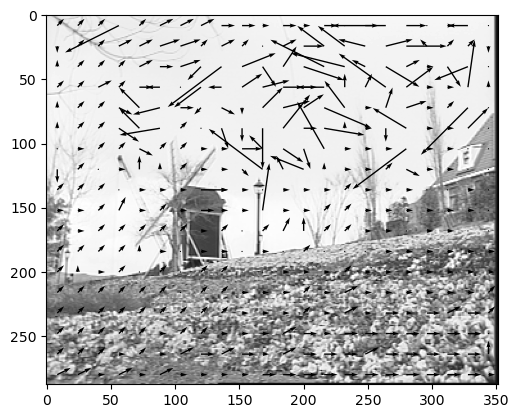

In [9]:
displayMVF(im1,mvf_ssd,brow)

**Q2:** Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image using the fracMc function. Display the motion compensated image. What can you observe ?

**A2:** The motion-compensated image appears well-aligned with both the reference and current frames. This suggests that the motion estimation effectively captured the movement between frames. However we can also see some minor atifacts and blurring since we're dealing with approximations. 


In [10]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x761028ae27b0>)

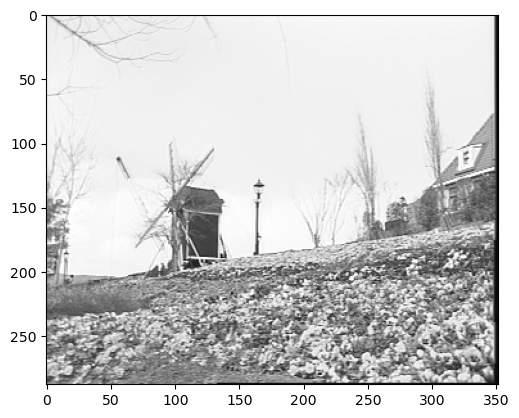

In [11]:
mc_ssd = fracMc(im1,mvf_ssd)
plt.figure(),plt.imshow(mc_ssd,cmap='gray')

Compute the PSNR between the motion compensated and the current images.

**Q3:** Recall the definition of PSNR. Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

**A3:** 

$$
PSNR = 10 \cdot \log_{10} \left( \frac{MAX^2_I}{MSE} \right)
$$

The PSNR measures the quality of the image by comparing an image to its reference. A higher PSNR means less distortion and thus indicates a higher quality. 

The PSNR of the motion-compensated image with im2 is higher than the PSNR of im1/im2. 

im2 is more similar to the compensated image than to im1.

Since the only difference when computing the PSNR of im1/im2 and motion-compensated image with im2 is going to be the MSE, it makes sense that the PSNR of the motion-compensated image with im2 is higher since the MSE of this case is lower.

In [12]:
def PSNR(im1,im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : nparray
        Two images.

    Returns
    -------
    psnr : float
    """
    
    mse = np.mean((im1 - im2)**2)
    psnr = 10 * np.log10((255 ** 2) / mse)
    
    return psnr

In [13]:
psnr_ssd = PSNR(im2,mc_ssd)
print(psnr_ssd)

22.503088328982088


In [14]:
lambs_vary = [0,1,10]
search_radius_vary = [4, 8, 16]
bcol_vary = [2, 4, 32]
brow_vary = bcol 

psnrs_reg = []
psnr_searchrad = []
psnrs_blocksize = []


print("Regularization change")
for idx, l in enumerate(lambs_vary):
    mvf_ssd_psnr, _ =  me_ssd(im2, im1, brow, bcol, search_radius, lamb=l)
    mc_ssd = fracMc(im1,mvf_ssd_psnr)
    
    psnr_ssd = PSNR(im2,mc_ssd)
    psnrs_reg.append(psnr_ssd)
    print(f"For lambda value {l}, psnr is {psnr_ssd}")

    
print("Search radius change")
for idx, r in enumerate(search_radius_vary):
    mvf_ssd_psnr, _ =  me_ssd(im2, im1, brow, bcol, r)
    mc_ssd = fracMc(im1,mvf_ssd_psnr)
    
    psnr_ssd = PSNR(im2,mc_ssd)
    psnrs_reg.append(psnr_ssd)
    print(f"For search radius value {r}, psnr is {psnr_ssd}")
    

print("Block size change")
for idx, l in enumerate(bcol_vary):
    mvf_ssd_psnr, _ =  me_ssd(im2, im1, l, l, search_radius)
    mc_ssd = fracMc(im1,mvf_ssd_psnr)
    
    psnr_ssd = PSNR(im2,mc_ssd)
    psnrs_reg.append(psnr_ssd)
    print(f"For block size value {l},{l}; psnr is {psnr_ssd}")


Regularization change
For lambda value 0, psnr is 22.503088328982088
For lambda value 1, psnr is 22.492704919900678
For lambda value 10, psnr is 22.264269589302454
Search radius change
For search radius value 4, psnr is 22.505819601465934
For search radius value 8, psnr is 22.503088328982088
For search radius value 16, psnr is 22.527546846409265
Block size change
For block size value 2,2; psnr is 30.253316194222315
For block size value 4,4; psnr is 24.28262334811808
For block size value 32,32; psnr is 21.99805209156469


### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the unregularized part of the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [15]:
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV
#%%
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    m, n = cur.shape
    # Non-regularized search
    if lamb == 0.:
        for r in range(0, m, bcol): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, n, brow):
                # current block selection
                B = cur[r : r + brow, c : c + bcol] # Block
                
                # Initialization:
                
                costMin = np.inf
                
                Rbest = np.zeros((brow, bcol))

                # Loop on candidate displacement vectors
                for dcol in range(c-search,search+c): # dcol = candidate displacement vector over the columns
                    for drow in range(r-search,search+r):# rcol = candidate displacement vector over the rows
                        
                        B_ref = ref_extended[
                        extension + drow : extension + brow + drow,
                        extension + dcol : extension + bcol + dcol
                        ]

                        cost = np.linalg.norm(B - B_ref, ord = 1)
                        
                        if cost <= costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            r_disp = drow
                            c_disp = dcol
                            Rbest = B_ref 
                            
                mvf[r : r + brow, c : c + bcol,0] = r - r_disp # Once the loop is over, save the best row displacement field
                mvf[r : r + brow, c : c + bcol,1] = c - c_disp # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol] = Rbest 

                
    else: # Regularized search
        for r in range(0, m, brow) : # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, n , bcol) :
                # current block selection
                B = cur[r : r + brow, c : c + bcol] # Block

                # Initializations          
                
                costMin = np.inf
                Rbest = np.zeros((brow, bcol))
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur) 
                
                # Loop on candidate vectors
                for dcol in range(c-search,search+c): # dcol = candidate displacement vector over the columns
                    for drow in range(r-search,search+r): # rcol = candidate displacement vector over the rows
                        
                        B_ref = ref_extended[
                        extension +  drow : extension + brow + drow,
                        extension + dcol : extension + bcol + dcol
                        ]
                        
                        reg_term = lamb * np.sum(np.abs((np.array([drow, dcol]) - pV)))
                        sad = np.linalg.norm(B - B_ref, ord = 1)
                        cost = sad + reg_term # here, encore the REGULARIZED cost function
                        if cost <= costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            r_disp = drow
                            c_disp = dcol
                            Rbest = B_ref
                
                
                mvf[r : r + brow, c : c + bcol,0] = r - r_disp  # Once the loop is over, save the best row displacement field
                mvf[r : r + brow, c : c + bcol,1] = c - c_disp  # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest
        
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [16]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius)

**Q4:** Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.

**A4:**  We can see magnitude differences between SSD and SAD plotted below. 

Some differences are expected since the SAD is more robust and reduces the influence of outliers, producing smoother, more consistent motion fields. SSD can cause abrupt changes in motion vectors.


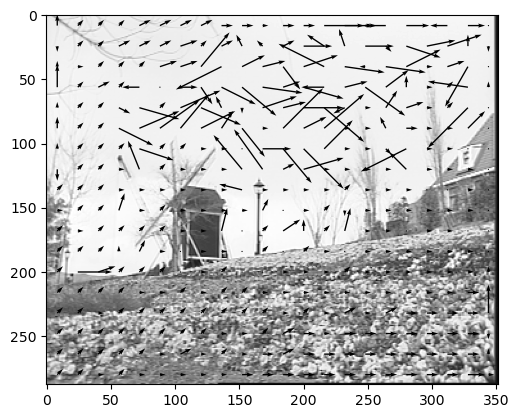

In [17]:
displayMVF(im1,mvf_sad,brow)

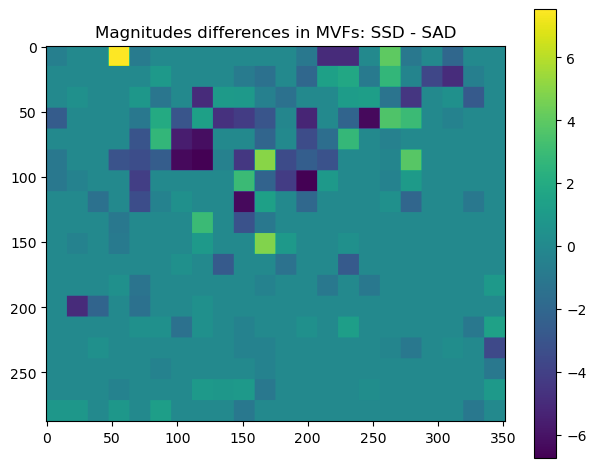

In [18]:
plt.figure()

plt.imshow(np.linalg.norm(mvf_ssd, ord=2, axis=2) - np.linalg.norm(mvf_sad, ord=2, axis=2))

plt.title("Magnitudes differences in MVFs: SSD - SAD")
plt.colorbar()
plt.tight_layout()
plt.show()


Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

**Q5:** Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

**A5:** 


SSD is highly sensitive to outliers, leading to erratic motion vectors and inaccurate motion estimation. SAD is more robust, reducing the influence of outliers and producing smoother, more consistent motion fields. SSD can cause abrupt changes in motion vectors, while SAD maintains a more stable flow. Smaller blocks capture finer details but introduce more noise, whereas larger blocks result in smoother motion estimation but may lose precision.

However despite SAD being more robust, our results show very similar results with the PSNR differing only of approximately 0.2 one from the other. 

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x761029383200>)

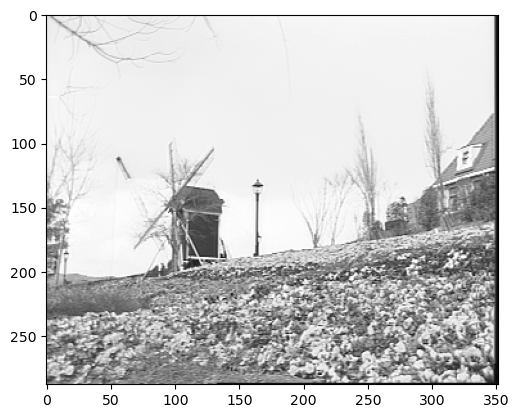

In [19]:
mc_sad = fracMc(im1,mvf_sad)
plt.figure(),plt.imshow(mc_sad,cmap='gray')

In [20]:
psnr_sad = PSNR(im2,mc_sad)
print(psnr_sad)

22.307261424452584


## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

TO DO : code the regularized SSD-based algorithm.
For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

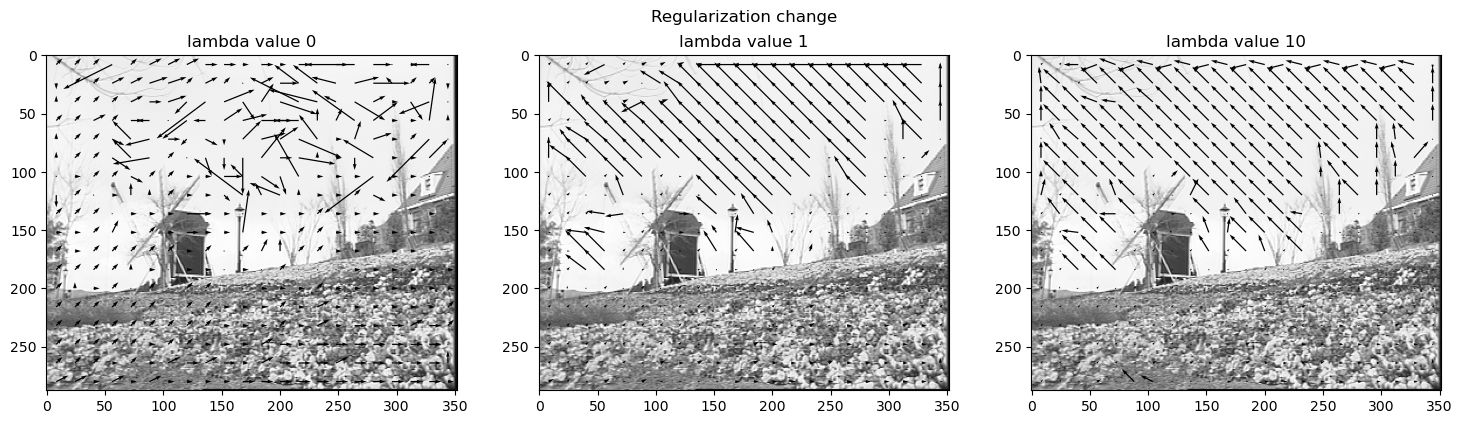

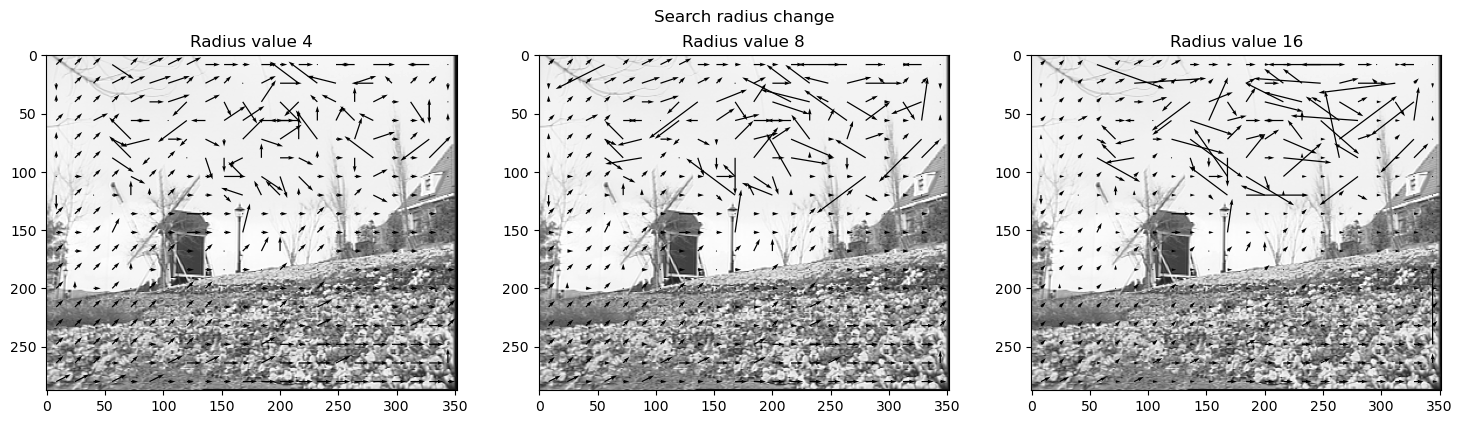

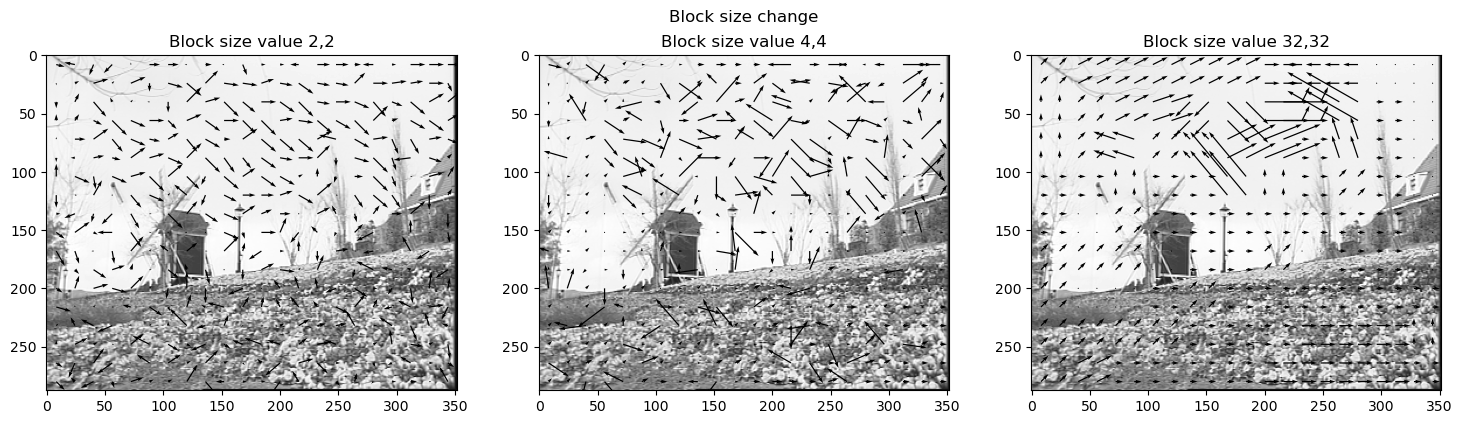

In [21]:
lambs_vary = [0,1,10]
search_radius_vary = [4, 8, 16]
bcol_vary = [2, 4, 32]
brow_vary = bcol 

plt.figure(figsize=(18,5))
plt.title("Regularization change")
plt.axis('off')
for idx, l in enumerate(lambs_vary):
    plt.subplot(1,len(lambs_vary), idx+1)
    plt.title(f"lambda value {l}")
    mvf_ssd_plt, prediction_plt =  me_ssd(im2, im1, brow, bcol, search_radius, lamb=l)
    displayMVF(im1,mvf_ssd_plt,brow,subplot=True)
    
plt.figure(figsize=(18,5))
plt.title("Search radius change")
plt.axis('off')
for idx, r in enumerate(search_radius_vary):
    plt.subplot(1,len(search_radius_vary), idx+1)
    plt.title(f"Radius value {r}")
    mvf_ssd_plt, prediction_plt =  me_ssd(im2, im1, brow, bcol, r)
    displayMVF(im1,mvf_ssd_plt,brow,subplot=True)

plt.figure(figsize=(18,5))
plt.title("Block size change")
plt.axis('off')
for idx, l in enumerate(bcol_vary):
    plt.subplot(1,len(bcol_vary), idx+1)
    plt.title(f"Block size value {l},{l}")
    mvf_ssd_plt, prediction_plt =  me_ssd(im2, im1, l, l, search_radius)
    displayMVF(im1,mvf_ssd_plt,brow,subplot=True)

### I-2-2- Regularized SAD-based algorithm

TO DO : code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

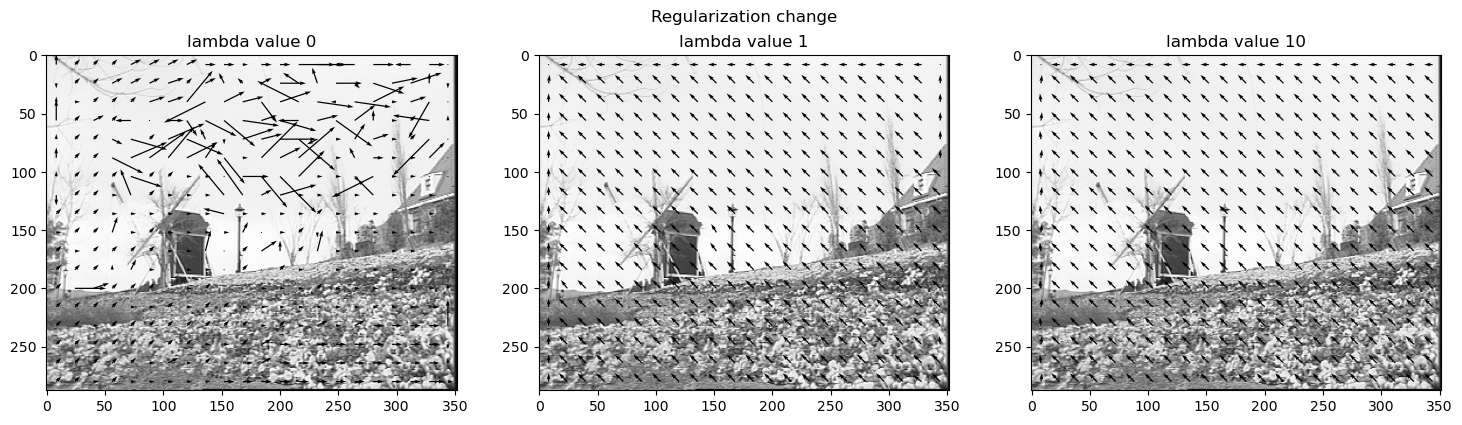

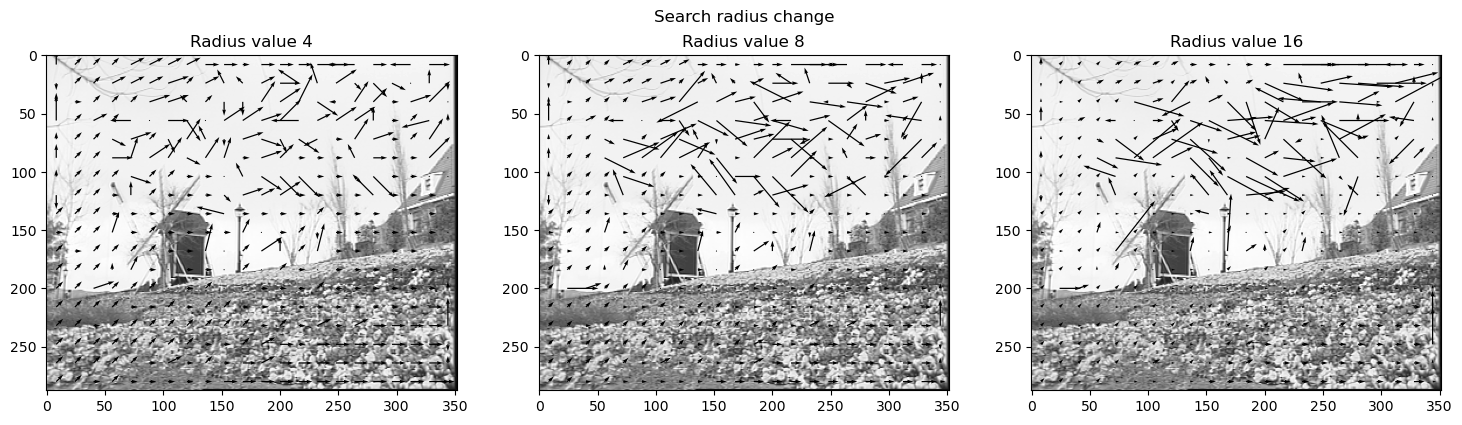

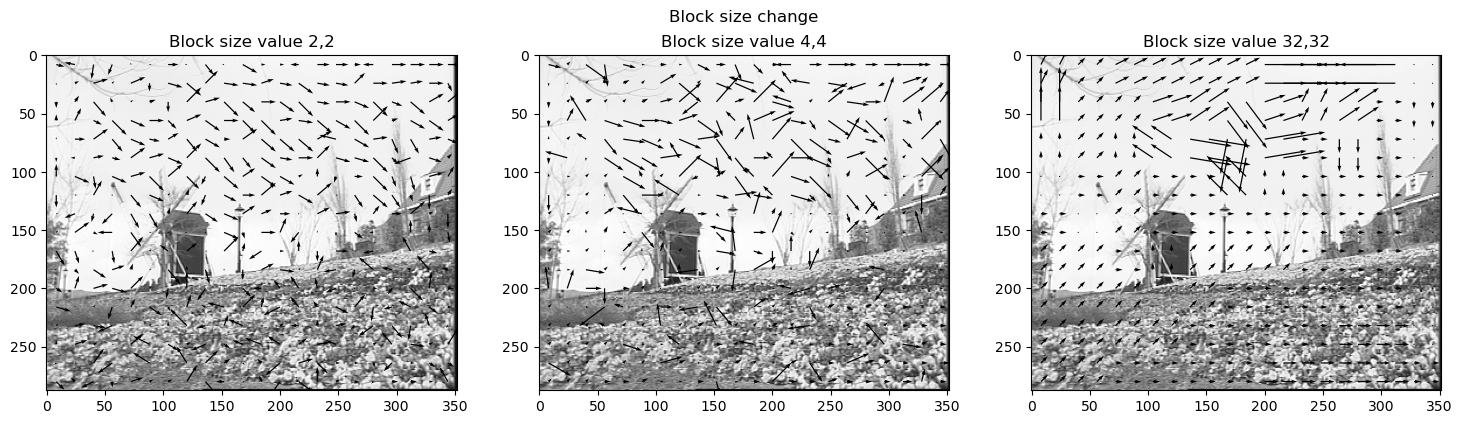

In [22]:
lambs_vary = [0,1,10]
search_radius_vary = [4, 8, 16]
bcol_vary = [2, 4, 32]
brow_vary = bcol 

plt.figure(figsize=(18,5))
plt.title("Regularization change")
plt.axis('off')
for idx, l in enumerate(lambs_vary):
    plt.subplot(1,len(lambs_vary), idx+1)
    plt.title(f"lambda value {l}")
    mvf_ssd_plt, prediction_plt =  me_sad(im2, im1, brow, bcol, search_radius, lamb=l)
    displayMVF(im1,mvf_ssd_plt,brow,subplot=True)
    
plt.figure(figsize=(18,5))
plt.title("Search radius change")
plt.axis('off')
for idx, r in enumerate(search_radius_vary):
    plt.subplot(1,len(search_radius_vary), idx+1)
    plt.title(f"Radius value {r}")
    mvf_ssd_plt, prediction_plt =  me_sad(im2, im1, brow, bcol, r)
    displayMVF(im1,mvf_ssd_plt,brow,subplot=True)

plt.figure(figsize=(18,5))
plt.title("Block size change")
plt.axis('off')
for idx, l in enumerate(bcol_vary):
    plt.subplot(1,len(bcol_vary), idx+1)
    plt.title(f"Block size value {l},{l}")
    mvf_ssd_plt, prediction_plt =  me_sad(im2, im1, l, l, search_radius)
    displayMVF(im1,mvf_ssd_plt,brow,subplot=True)

# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [23]:
im1 = loadmat('akiyo_cif1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('akiyo_cif2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x761026b5d670>)

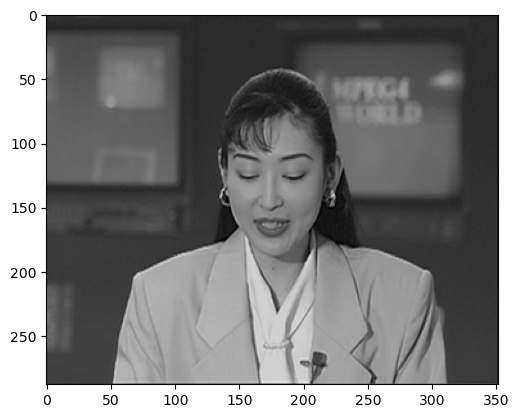

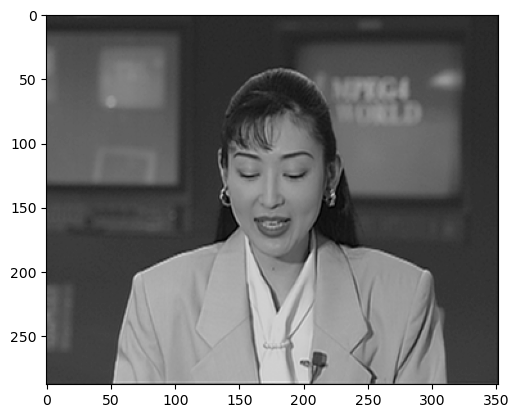

In [24]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithm to initialize the Horn and Schunck method.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

In [25]:
brow = 16; bcol=16; search_radius =13;

...



Ellipsis

In [26]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg = convolve2d(u, kernel_1, 'same')
        vAvg = convolve2d(v, kernel_1, 'same')
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        den = alpha**2 + np.sum(fx**2 + fy**2) 
        num = uAvg*fx + vAvg*fy + ft
        u = uAvg - fx * num/den
        v = vAvg - fy * num/den
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

In [27]:
alpha = 100
ite = 100
mvf_sad,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

uInitial = mvf_sad[:,:,0] # Rem: pay attention to the inversion of the order compared to me_ssd.
vInitial = mvf_sad[:,:,1]
[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

**A:**

Horn-Schunck and Block Matching both estimate motion but differ in approach. Horn-Schunck provides a smooth, dense motion field by enforcing global consistency, making it better for capturing small, gradual movements. Block Matching, though simpler and effective for large motions, can produce discontinuities at block edges and lacks smoothness. Compared to Block Matching, Horn-Schunck improves motion coherence, reducing abrupt changes, but is more sensitive to noise and computationally intensive.

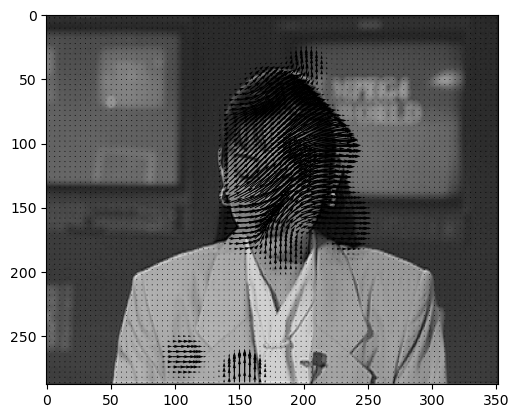

In [28]:
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)

mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

In [29]:
psnr_hs

32.052367407425905